In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class Layer:
    __slots__ = [
        # weights 
        "weights",
        "weights_gradient",
        "weights_momentum",
        "weights_gradient_squared",
        "weights_changes",

        # biases
        "biases",
        "biases_gradient",
        "biases_changes",
        "biases_momentum",
        "biases_gradient_squared",

        # activation functions
        "activation",
        "activation_derivative",

        # backpropagation
        "delta",
        "a",
        "z",
    ]

    def __init__(self, nodes_in, nodes_out, activation="sigmoid"):
        self.weights = np.random.normal(size=(nodes_in, nodes_out), scale=1)
        self.biases = np.random.normal(size=(1, nodes_out))
        self.biases_gradient = np.zeros(self.biases.shape)
        self.weights_gradient = np.zeros(self.weights.shape)
        self.biases_changes = np.zeros(self.biases.shape)
        self.weights_changes = np.zeros(self.weights.shape)
        self.biases_momentum = np.zeros(self.biases.shape)
        self.weights_momentum = np.zeros(self.weights.shape)
        self.biases_gradient_squared = np.zeros(self.biases.shape)
        self.weights_gradient_squared = np.zeros(self.weights.shape)

        if activation == "sigmoid":
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == "linear":
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative

    def calculate_layer(self, input):
        """
        Calculate the output of the layer
        Takes in a numpy array and returns a numpy array
        """
        return self.activation(np.dot(input, self.weights) + self.biases)

    def calculate_layer_and_before_activation(self, input):
        """
        Calculate the output of the layer and the output before the activation function
        Takes in a numpy array and returns a numpy array
        """
        return np.dot(input, self.weights) + self.biases, self.activation(np.dot(input, self.weights) + self.biases)

    def sigmoid(self, x):
        """
        Sigmoid activation function
        Takes in a numpy array and returns a numpy array
        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """
        Sigmoid derivative function
        Takes in a numpy array and returns a numpy array
        """
        return x * (1 - x)

    def linear(self, x):
        """
        Linear activation function
        Takes in a numpy array and returns a numpy array
        """
        return x

    def linear_derivative(self, x):
        """
        Linear derivative function
        Takes in a numpy array and returns a numpy array
        """
        return np.ones_like(x)

    def report_layer(self, layer_num):
        return (
            f"Layer number {layer_num}\nWeights\n{self.weights}\nbiases\n{self.biases}"
        )

    def apply_gradient(self, learning_rate):
        self.weights -= learning_rate * self.weights_gradient
        self.biases -= learning_rate * self.biases_gradient

    def apply_changes(self):
        self.weights += self.weights_changes
        self.biases += self.biases_changes

    def calculate_momentum(self, momentum_decay):
        self.biases_momentum =  momentum_decay * self.biases_momentum + (1 - momentum_decay) * self.biases_gradient
        self.weights_momentum = momentum_decay * self.weights_momentum + (1 - momentum_decay) * self.weights_gradient

    def calculate_gradient_squared(self, decay_rate):
        self.biases_gradient_squared = decay_rate * self.biases_gradient_squared + (1 - decay_rate) * self.biases_gradient ** 2
        self.weights_gradient_squared = decay_rate * self.weights_gradient_squared + (1 - decay_rate) * self.weights_gradient ** 2

    def calculate_changes(self, learning_rate, epsilon, t, momentum_decay, decay_rate):
        self.weights_changes = (- learning_rate / (np.sqrt(self.weights_gradient_squared / (
            1 - decay_rate **t
        )) + epsilon)) * self.weights_momentum / (1 - momentum_decay**t)

        self.biases_changes = (
            - learning_rate / (np.sqrt(self.biases_gradient_squared / (
            1 - decay_rate **t) + epsilon)
        ) * self.biases_momentum / (1 - momentum_decay**t))

In [4]:
class NeuralNetwork:
    __slots__ = ["hidden_layers", "layers"]

    def __init__(self, hidden_layers, input_size, output_size):
        self.hidden_layers = hidden_layers
        self.layers = []

        # Create the input layer
        input_layer = Layer(1, hidden_layers[0])
        self.layers.append(input_layer)

        # Create the hidden layers
        for input_size, output_size in zip(hidden_layers, hidden_layers[1:]):
            self.layers.append(Layer(input_size, output_size))

        # Create the output layer
        output_layer = Layer(hidden_layers[-1], 1, activation="linear")
        self.layers.append(output_layer)

    def forward(self, input):
        """
        Takes a input and returns the output of the network
        """
        for layer in self.layers:
            input = layer.calculate_layer(input)
        return input

    def train(
        self, input, output, learning_rate=0.003, batch_size_frac=0.1, epochs=30000
    ):
        """
        Train the network on a given dataset
        """
        mse_list = []
        for epoch in range(epochs):
            merged = input.to_frame().join(output)
            merged = merged.sample(frac=batch_size_frac)
            self.calculate_gradient(merged["x"], merged["y"])
            self.apply_gradient(learning_rate)
            mse = self.mean_squared_error(merged["x"], merged["y"])
            mse_list.append(mse)
            if epoch % 2000 == 0:
                print(f"Epoch {epoch} MSE: {mse}")
        return mse_list

    def backpropagation(self, input, output):
        """
        Perform backpropagation on the network
        """

        for x,y in zip(input, output):
            # Forward pass
            a = x
            for layer in self.layers:
                z, a = layer.calculate_layer_and_before_activation(a)
                layer.z = z
                layer.a = a

            # Backward pass
            # Calculate the delta for the output layer
            self.layers[-1].delta = self.mean_squared_error_gradient(
                self.layers[-1].a, y
            ) * self.layers[-1].activation_derivative(self.layers[-1].z)

            # Calculate the delta for the hidden layers
            for layer, next_layer in zip(self.layers[-2::-1], self.layers[-1::-1]):
                layer.delta = np.dot(
                    next_layer.delta, next_layer.weights.T
                ) * layer.activation_derivative(layer.a)


            # Calculate the gradients for the input layer
            self.layers[0].biases_gradient += self.layers[0].delta
            try:
                self.layers[0].weights_gradient += np.dot(x.T, self.layers[0].delta)
            except:
                self.layers[0].weights_gradient += np.dot(x, self.layers[0].delta)

            # Calculate the gradients for the hidden layers
            for previous_layer, layer in zip(self.layers, self.layers[1:]):
                layer.biases_gradient += layer.delta
                layer.weights_gradient += np.dot(previous_layer.a.T, layer.delta)

        for layer in self.layers:
            layer.biases_gradient = layer.biases_gradient / len(input)
            layer.weights_gradient = layer.weights_gradient / len(input)

    def mean_squared_error(self, input, output):
        """
        Calculate the mean squared error of the network on a given dataset and output
        """
        mse = []
        for i, j in zip(input, output):
            mse.append((j - self.forward(i)) ** 2)
        return np.mean(mse)

    def mean_squared_error_gradient(self, predicted, true):
        """
        Calculate the gradient of the mean squared error
        """
        return 2 * (predicted - true)

    def visualize(self):
        """
        Visualize the network architecture
        """
        for i, layer in enumerate(self.layers):
            print(layer.report_layer(i))
            print("\n")

    def apply_gradient(self, learning_rate):
        for layer in self.layers:
            layer.apply_gradient(learning_rate)

    def apply_changes(self):
        for layer in self.layers:
            layer.apply_changes()

    def calculate_momentum(self, momentum_decay):
        for layer in self.layers:
            layer.calculate_momentum(momentum_decay)

    def calculate_gradient_squared(self, decay_rate):
        for layer in self.layers:
            layer.calculate_gradient_squared(decay_rate)

    def calculate_changes(self, learning_rate, epsilon, t, momentum_decay, decay_rate):
        for layer in self.layers:
            layer.calculate_changes(learning_rate, epsilon, t, momentum_decay, decay_rate)

    def calculate_gradient(self, input, output):
        """
        Calculate the gradient of the network
        """
        h = 0.0000001
        original_mse = self.mean_squared_error(input, output)

        for layer in self.layers:
            for i in range(layer.weights.shape[0]):
                for j in range(layer.weights.shape[1]):
                    layer.weights[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.weights_gradient[i, j] = (new_mse - original_mse) / h
                    layer.weights[i, j] -= h

            for i in range(layer.biases.shape[0]):
                for j in range(layer.biases.shape[1]):
                    layer.biases[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.biases_gradient[i, j] = (new_mse - original_mse) / h
                    layer.biases[i, j] -= h

    def adam(
        self,
        X,y,
        learning_rate=0.01,
        momentum_decay=0.9,
        squared_gradient_decay=0.999,
        max_num_epoch=1000,
        batch_size=1,
        batch_fraction=None,
        epsilon=1e-8,
        ):

        # initialization
        if type(X) is pd.DataFrame:
            X = X.to_numpy()
        if type(y) is pd.DataFrame:
            y = y.to_numpy().T
        counter = 0

        # set batch size
        assert type(batch_size) is int, "batch_size must be an integer"
        if batch_fraction is not None:
            assert 0 < batch_fraction <= 1, "batch_fraction must be between 0 and 1"
            batch_size = int(X.shape[0] * batch_fraction)
        iterations = int(X.shape[0] / batch_size)
        mse_list = []

        for i in range(max_num_epoch):
            N = X.shape[0]
            shuffled_idx = np.random.permutation(N)
            # X, y = X[shuffled_idx], y[shuffled_idx]
            for idx in range(iterations):
                X_selected, y_selected = (
                    X[idx * batch_size : (idx + 1) * batch_size],
                    y[idx * batch_size : (idx + 1) * batch_size],
                )
                self.calculate_gradient(X_selected, y_selected)
                self.calculate_momentum(momentum_decay)
                self.calculate_gradient_squared(squared_gradient_decay)
                counter += 1

                self.calculate_changes(learning_rate, epsilon, counter, momentum_decay, squared_gradient_decay)
                self.apply_changes()
                mse_list.append(self.mean_squared_error(X_selected, y_selected))

            print("Epoch:", i)
        return mse_list


    def adam_debug(
        self,
        X,y,
        learning_rate=0.01,
        momentum_decay=0.9,
        squared_gradient_decay=0.999,
        max_num_epoch=1000,
        batch_size=1,
        batch_fraction=None,
        epsilon=1e-8,
        silent=False
        ):

        # initialization
        if type(X) is pd.DataFrame:
            X = X.to_numpy()
        if type(y) is pd.DataFrame:
            y = y.to_numpy().T
        counter = 0

        # set batch size
        assert type(batch_size) is int, "batch_size must be an integer"
        if batch_fraction is not None:
            assert 0 < batch_fraction <= 1, "batch_fraction must be between 0 and 1"
            batch_size = int(X.shape[0] * batch_fraction)
        iterations = int(X.shape[0] / batch_size)
        mse_list = []

        for i in range(max_num_epoch):
            N = X.shape[0]
            shuffled_idx = np.random.permutation(N)
            # X, y = X[shuffled_idx], y[shuffled_idx]
            for idx in range(iterations):
                X_selected, y_selected = (
                    X[idx * batch_size : (idx + 1) * batch_size],
                    y[idx * batch_size : (idx + 1) * batch_size],
                )
                self.backpropagation(X_selected, y_selected)

                self.calculate_momentum(momentum_decay)
                self.calculate_gradient_squared(squared_gradient_decay)
                counter += 1

                self.calculate_changes(learning_rate, epsilon, counter, momentum_decay, squared_gradient_decay)
                self.apply_changes()
                mse_list.append(self.mean_squared_error(X_selected, y_selected))
            if not silent:
                print("Epoch:", i)
        return mse_list

In [5]:
square_simple_train = pd.read_csv("../data/regression/square-simple-training.csv", index_col=0)
square_simple_test = pd.read_csv("../data/regression/square-simple-test.csv", index_col=0)

In [6]:
mean = square_simple_train.mean()
std = square_simple_train.std()
square_simple_train_normalized = (square_simple_train - mean) / std
square_simple_test_normalized = (square_simple_test - mean) / std


In [14]:
neural = NeuralNetwork([5], 1, 1)
mse = neural.adam_debug(
    square_simple_train_normalized["x"],
    square_simple_train_normalized["y"],
    max_num_epoch=1000,
    learning_rate=0.05,
    batch_fraction=0.5,
    silent=True,
)
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
) * std["y"] ** 2

0.21778582324454213

Text(0, 0.5, 'MSE')

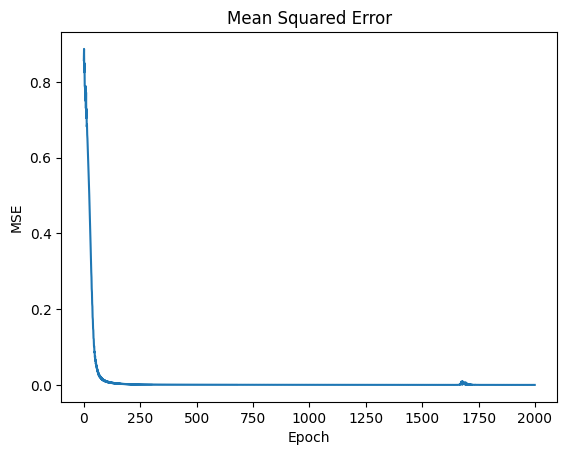

In [10]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

0.5760188604834714

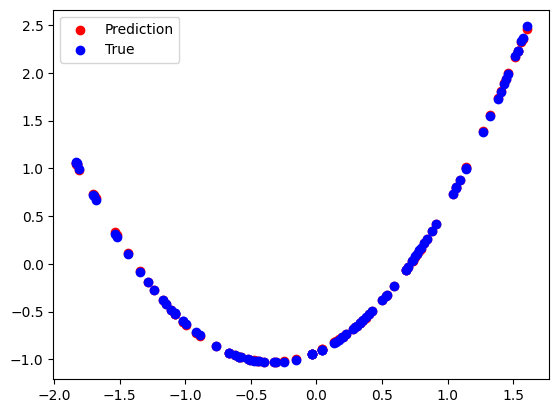

In [12]:
y = []
for i in square_simple_train_normalized["x"]:
    y.append(neural.forward(i))
plt.scatter(square_simple_train_normalized["x"], y, c="red")
plt.scatter(
    square_simple_train_normalized["x"],
    square_simple_train_normalized["y"],
    c="blue",
)
plt.legend(["Prediction", "True"])
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
) * std["y"] ** 2